In [1]:
import numpy as np
import matplotlib.pyplot as plt
from medpy import io
from radiomics import featureextractor, imageoperations
import six
import os
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
%load_ext autoreload
%autoreload 2
#sys.path.append('../')
#from data_scripts.PI_CAI_Detection import PI_CAI_Detection
from radiomics_util import *

In [7]:
gt = pd.read_csv("/data1/practical-sose23/morphometric/picai_labels/clinical_information/marksheet.csv")
gt.head()

patient_id  study_id    mri_date  patient_age   psa  psad  prostate_volume  \
0       10000   1000000  2019-07-02           73   7.7   NaN             55.0   
1       10001   1000001  2016-05-27           64   8.7  0.09            102.0   
2       10002   1000002  2021-04-18           58   4.2  0.06             74.0   
3       10003   1000003  2019-04-05           72  13.0   NaN             71.5   
4       10004   1000004  2020-10-21           67   8.0  0.10             78.0   

  histopath_type lesion_GS lesion_ISUP  case_ISUP case_csPCa  
0           MRBx       0+0           0          0         NO  
1            NaN       NaN         NaN          0         NO  
2            NaN       NaN         NaN          0         NO  
3          SysBx       0+0           0          0         NO  
4     SysBx+MRBx   0+0,0+0         0,0          0         NO

# Collect Information


In [30]:
# this calculates the number of pixels between the prostate and all borders
def get_border(mask):
    array = sitk.GetArrayFromImage(mask)
    from scipy.ndimage import find_objects

    # Find the bounding box coordinates
    
    bounding_box = find_objects(array)[0]

    # Calculate the padding distances
    padding_z_start = bounding_box[0].start
    padding_z_end = array.shape[0] - bounding_box[0].stop
    padding_x_start = bounding_box[1].start
    padding_x_end = array.shape[1] - bounding_box[1].stop
    padding_y_start = bounding_box[2].start
    padding_y_end = array.shape[2] - bounding_box[2].stop

    # Print the padding distances
    result = {
    "Padding X (Start)": padding_x_start,
    "Padding X (End)": padding_x_end,
    "Padding Y (Start)": padding_y_start,
    "Padding Y (End)": padding_y_end,
    "Padding Z (Start)": padding_z_start,
    "Padding Z (End)": padding_z_end,
    "Width X" : bounding_box[1].stop - bounding_box[1].start,
    "Width Y" : bounding_box[2].stop - bounding_box[2].start,
    "Width Z" : bounding_box[0].stop - bounding_box[0].start,
    "Size X" : array.shape[1],
    "Size Y" : array.shape[2],
    "Size Z" : array.shape[0],
    "Center_X" : bounding_box[1].stop - (bounding_box[1].stop - bounding_box[1].start)/2,
    "Center_Y" : bounding_box[2].stop - (bounding_box[2].stop - bounding_box[2].start)/2,
    "Center_Z" : bounding_box[0].stop - (bounding_box[0].stop - bounding_box[0].start)/2,
    }
    return result


In [31]:
image, mask = get_image_and_segmentaion(10008, 1000008)

get_border(mask)

{'Padding X (Start)': 78,
 'Padding X (End)': 71,
 'Padding Y (Start)': 72,
 'Padding Y (End)': 69,
 'Padding Z (Start)': 3,
 'Padding Z (End)': 4,
 'Width X': 43,
 'Width Y': 51,
 'Width Z': 13,
 'Size X': 192,
 'Size Y': 192,
 'Size Z': 20,
 'Center_X': 99.5,
 'Center_Y': 97.5,
 'Center_Z': 9.5}

In [32]:
df = pd.DataFrame([])

for index, row in gt.iterrows():
    if isinstance(row['prostate_volume'], float):
        print("Iteration:", str(index), end="\r")
        image, mask = get_image_and_segmentaion(row["patient_id"], row["study_id"])
        
        new_row = {"study_id": row["study_id"], 
                   "patient_id": row["patient_id"],
                   "spacing_0" : image.GetSpacing()[0],
                   "spacing_1" : image.GetSpacing()[1],
                    "spacing_2" : image.GetSpacing()[2],
                    "size_0" :  image.GetSize()[0],
                    "size_1" :  image.GetSize()[1],
                    "size_2" :  image.GetSize()[2],
                    "origin" : image.GetOrigin(),
                    "real_dimension_0" : image.GetSpacing()[0] * image.GetSize()[0],
                    "real_dimension_1": image.GetSpacing()[1] * image.GetSize()[1],
                    "real_dimension_2": image.GetSpacing()[2] * image.GetSize()[2],
        }

        borders = get_border(mask)
        new_row.update(borders)
        
        df = df.append(new_row, ignore_index=True)

df

study_id  patient_id  spacing_0  spacing_1  spacing_2  size_0  size_1  \
0     1000000.0     10000.0        1.0        1.0        3.0   180.0   180.0   
1     1000001.0     10001.0        1.0        1.0        3.0   192.0   192.0   
2     1000002.0     10002.0        1.0        1.0        3.0   192.0   192.0   
3     1000003.0     10003.0        1.0        1.0        3.0   192.0   192.0   
4     1000004.0     10004.0        1.0        1.0        3.0   192.0   192.0   
...         ...         ...        ...        ...        ...     ...     ...   
1493  1001494.0     11470.0        1.0        1.0        3.0   180.0   180.0   
1494  1001495.0     11471.0        1.0        1.0        3.0   192.0   192.0   
1495  1001496.0     11472.0        1.0        1.0        3.0   192.0   192.0   
1496  1001497.0     11473.0        1.0        1.0        3.0   192.0   192.0   
1497  1001498.0     11474.0        1.0        1.0        3.0   195.0   195.0   

      size_2                                             origin  \
0       34.0  (-109.22891616821, -76.614260508237, -84.29311...   
1       25.0  (-119.80861242576, -65.872387498812, -38.77975...   
2       22.0  (-75.958717345721, -101.90842263373, 12.320441...   
3       23.0  (-75.050601958758, -69.85840339031, -25.163462...   
4       25.0  (-81.364946364887, -95.368903586534, -26.19577...   
...      ...                                                ...   
1493    27.0  (-88.647385235846, -91.484593589353, -3.017166...   
1494    22.0  (-97.750484605452, -77.4502615813, 22.10853373...   
1495    22.0  (-97.75048839999, -69.636696595946, -10.762666...   
1496    25.0  (-134.6929564654, -68.377214345749, 10.8437984...   
1497    27.0  (-79.82086103324595, -90.33997085067111, -44.7...   

      real_dimension_0  ...  Padding Z (End)  Width X  Width Y  Width Z  \
0                180.0  ...             13.0     34.0     51.0     13.0   
1                192.0  ...              4.0     52.0     57.0     19.0   
2                192.0  ...              3.0     51.0     55.0     15.0   
3                192.0  ...              3.0     51.0     52.0     16.0   
4                192.0  ...              5.0     42.0     59.0     17.0   
...                ...  ...              ...      ...      ...      ...   
1493             180.0  ...              9.0     36.0     48.0     13.0   
1494             192.0  ...              4.0     41.0     56.0     14.0   
1495             192.0  ...              7.0     32.0     51.0     13.0   
1496             192.0  ...              5.0     49.0     54.0     16.0   
1497             195.0  ...              5.0     52.0     56.0     18.0   

      Size X  Size Y  Size Z  Center_X  Center_Y  Center_Z  
0      180.0   180.0    34.0      94.0      79.5      14.5  
1      192.0   192.0    25.0      96.0      97.5      11.5  
2      192.0   192.0    22.0     100.5     100.5      11.5  
3      192.0   192.0    23.0      92.5      91.0      12.0  
4      192.0   192.0    25.0     105.0      99.5      11.5  
...      ...     ...     ...       ...       ...       ...  
1493   180.0   180.0    27.0      93.0      91.0      11.5  
1494   192.0   192.0    22.0     101.5      92.0      11.0  
1495   192.0   192.0    22.0     101.0      94.5       8.5  
1496   192.0   192.0    25.0      93.5      97.0      12.0  
1497   195.0   195.0    27.0      79.0      96.0      13.0  

[1498 rows x 27 columns]

In [33]:
df.to_pickle("./image_spacing_metadata.pkl")

# Check results

In [37]:
df = pd.read_pickle("image_spacing_metadata.pkl")
df.head()

study_id  patient_id  spacing_0  spacing_1  spacing_2  size_0  size_1  \
0  1000000.0     10000.0        1.0        1.0        3.0   180.0   180.0   
1  1000001.0     10001.0        1.0        1.0        3.0   192.0   192.0   
2  1000002.0     10002.0        1.0        1.0        3.0   192.0   192.0   
3  1000003.0     10003.0        1.0        1.0        3.0   192.0   192.0   
4  1000004.0     10004.0        1.0        1.0        3.0   192.0   192.0   

   size_2                                             origin  \
0    34.0  (-109.22891616821, -76.614260508237, -84.29311...   
1    25.0  (-119.80861242576, -65.872387498812, -38.77975...   
2    22.0  (-75.958717345721, -101.90842263373, 12.320441...   
3    23.0  (-75.050601958758, -69.85840339031, -25.163462...   
4    25.0  (-81.364946364887, -95.368903586534, -26.19577...   

   real_dimension_0  ...  Padding Z (End)  Width X  Width Y  Width Z  Size X  \
0             180.0  ...             13.0     34.0     51.0     13.0   180.0   
1             192.0  ...              4.0     52.0     57.0     19.0   192.0   
2             192.0  ...              3.0     51.0     55.0     15.0   192.0   
3             192.0  ...              3.0     51.0     52.0     16.0   192.0   
4             192.0  ...              5.0     42.0     59.0     17.0   192.0   

   Size Y  Size Z  Center_X  Center_Y  Center_Z  
0   180.0    34.0      94.0      79.5      14.5  
1   192.0    25.0      96.0      97.5      11.5  
2   192.0    22.0     100.5     100.5      11.5  
3   192.0    23.0      92.5      91.0      12.0  
4   192.0    25.0     105.0      99.5      11.5  

[5 rows x 27 columns]

dim 0
min: 67.5 529
mean: 94.83344459279039
max: 141.5 32


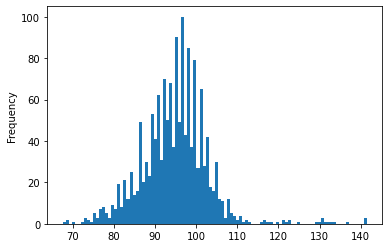

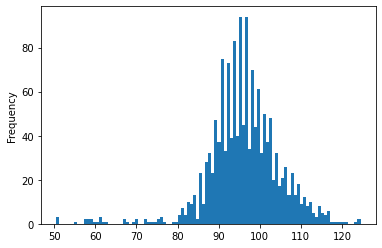

dim 1
min: 71.5 719
mean: 95.9175567423231
max: 130.5 366


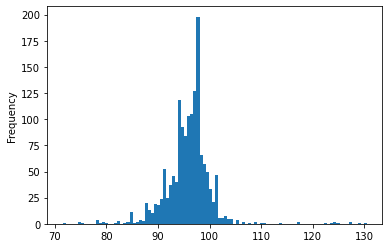

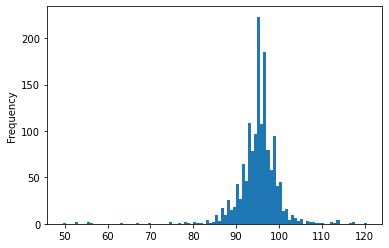

dim 2
min: 6.0 1487
mean: 11.50233644859813
max: 22.0 281


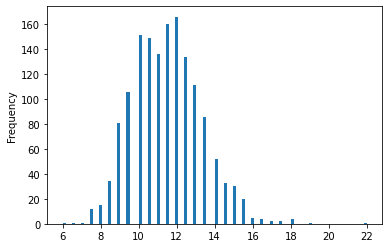

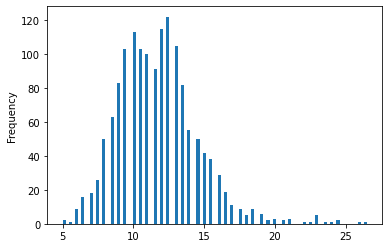

In [40]:
# plot the center of the prostate bounding boxes

print("dim 0")
print("min:",  df["Center_X"].min(),  df["Center_X"].idxmin())
print("mean:", df["Center_X"].mean())
print("max:",  df["Center_X"].max(),  df["Center_X"].idxmax())
df["Center_X"].plot.hist(bins=100)
plt.show()
(df["Size X"] - df["Center_X"]).plot.hist(bins=100)
plt.show()

print("dim 1")
print("min:",  df["Center_Y"].min(),  df["Center_Y"].idxmin())
print("mean:", df["Center_Y"].mean())
print("max:",  df["Center_Y"].max(),  df["Center_Y"].idxmax())
df["Center_Y"].plot.hist(bins=100)
plt.show()
(df["Size Y"] - df["Center_Y"]).plot.hist(bins=100)
plt.show()

print("dim 2")
print("min:",  df["Center_Z"].min(),  df["Center_Z"].idxmin())
print("mean:", df["Center_Z"].mean())
print("max:",  df["Center_Z"].max(),  df["Center_Z"].idxmax())
df["Center_Z"].plot.hist(bins=100)
plt.show()
(df["Size Z"] - df["Center_Z"]).plot.hist(bins=100)
plt.show()

dim 0
min: 25.0 690
mean: 43.43457943925234
max: 89.0 351


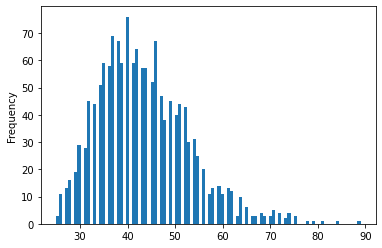

dim 1
min: 31.0 1435
mean: 52.89652870493992
max: 84.0 497


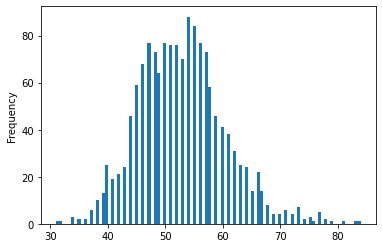

dim 2
min: 7.0 1175
mean: 14.965954606141523
max: 30.0 325


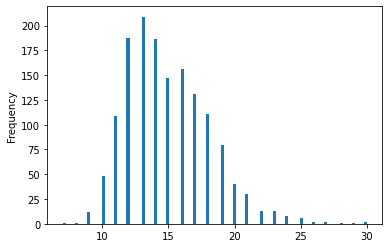

In [16]:
# plot the sizes of the prostate bounding boxes

print("dim 0")
print("min:",  df["Width X"].min(),  df["Width X"].idxmin())
print("mean:", df["Width X"].mean())
print("max:",  df["Width X"].max(),  df["Width X"].idxmax())
df["Width X"].plot.hist(bins=100)
plt.show()

print("dim 1")
print("min:",  df["Width Y"].min(),  df["Width Y"].idxmin())
print("mean:", df["Width Y"].mean())
print("max:",  df["Width Y"].max(),  df["Width Y"].idxmax())
df["Width Y"].plot.hist(bins=100)
plt.show()

print("dim 2")
print("min:",  df["Width Z"].min(),  df["Width Z"].idxmin())
print("mean:", df["Width Z"].mean())
print("max:",  df["Width Z"].max(),  df["Width Z"].idxmax())
df["Width Z"].plot.hist(bins=100)
plt.show()

=> Desired cropping target : 100x100x35

In [41]:
df.loc[df["Width Z"]>=25]

study_id  patient_id  spacing_0  spacing_1  spacing_2  size_0  size_1  \
145   1000145.0     10143.0        1.0        1.0        3.0   192.0   192.0   
325   1000325.0     10319.0        1.0        1.0        3.0   180.0   180.0   
351   1000351.0     10345.0        1.0        1.0        3.0   192.0   192.0   
388   1000388.0     10382.0        1.0        1.0        3.0   192.0   192.0   
483   1000483.0     10475.0        1.0        1.0        3.0   192.0   192.0   
497   1000497.0     10489.0        1.0        1.0        3.0   192.0   192.0   
502   1000502.0     10493.0        1.0        1.0        3.0   180.0   180.0   
731   1000731.0     10715.0        1.0        1.0        3.0   192.0   192.0   
1081  1001082.0     11060.0        1.0        1.0        3.0   192.0   192.0   
1200  1001201.0     11178.0        1.0        1.0        3.0   192.0   192.0   
1315  1001316.0     11293.0        1.0        1.0        3.0   192.0   192.0   
1319  1001320.0     11297.0        1.0        1.0        3.0   192.0   192.0   
1341  1001342.0     11319.0        1.0        1.0        3.0   192.0   192.0   
1484  1001485.0     11461.0        1.0        1.0        3.0   194.0   194.0   

      size_2                                             origin  \
145     28.0  (-87.14807512345, -78.425555991439, 30.4234942...   
325     33.0  (-97.684107156767, -52.033291765794, 62.201892...   
351     37.0  (-123.52753966888, -87.92397432463, -17.572016...   
388     33.0  (-75.581810017248, -54.299986730377, 35.857894...   
483     32.0  (-70.562324817982, -63.175690753516, -10.34051...   
497     26.0  (-97.750484605452, -66.477901292521, 0.9707464...   
502     30.0  (-93.528166770935, -85.450330254621, -51.72366...   
731     26.0  (-97.75048842015, -68.457801604388, -93.823537...   
1081    26.0  (-86.184223194739, -83.429636324839, -46.98635...   
1200    32.0  (-90.039645194538, -71.482404514441, -40.33546...   
1315    25.0  (-147.87096788468, -74.634620475081, 43.616174...   
1319    34.0  (-86.184223174579, -75.128834325777, -26.58214...   
1341    29.0  (-97.750484585292, -66.160432224957, -16.83484...   
1484    30.0  (-122.13401083861925, -98.26384231260734, 10.0...   

      real_dimension_0  ...  Padding Z (End)  Width X  Width Y  Width Z  \
145              192.0  ...              0.0     54.0     69.0     25.0   
325              180.0  ...              0.0     53.0     83.0     30.0   
351              192.0  ...              4.0     89.0     68.0     30.0   
388              192.0  ...              1.0     67.0     71.0     29.0   
483              192.0  ...              4.0     61.0     70.0     25.0   
497              192.0  ...              1.0     62.0     84.0     25.0   
502              180.0  ...              1.0     73.0     70.0     27.0   
731              192.0  ...              1.0     75.0     78.0     25.0   
1081             192.0  ...              0.0     70.0     77.0     26.0   
1200             192.0  ...              1.0     62.0     66.0     28.0   
1315             192.0  ...              0.0     65.0     59.0     25.0   
1319             192.0  ...              3.0     74.0     74.0     26.0   
1341             192.0  ...              2.0     68.0     76.0     25.0   
1484             194.0  ...              2.0     72.0     70.0     27.0   

      Size X  Size Y  Size Z  Center_X  Center_Y  Center_Z  
145    192.0   192.0    28.0      92.0      99.5      15.5  
325    180.0   180.0    33.0      82.5     101.5      18.0  
351    192.0   192.0    37.0      90.5      96.0      18.0  
388    192.0   192.0    33.0      95.5     100.5      17.5  
483    192.0   192.0    32.0      97.5      98.0      15.5  
497    192.0   192.0    26.0     102.0     125.0      12.5  
502    180.0   180.0    30.0      78.5      91.0      15.5  
731    192.0   192.0    26.0      86.5      97.0      12.5  
1081   192.0   192.0    26.0     100.0      98.5      13.0  
1200   192.0   192.0    32.0      89.0      97.0      17.0  
131

study_id                                                     1001320.0
patient_id                                                     11297.0
spacing_0                                                          1.0
spacing_1                                                          1.0
spacing_2                                                          3.0
size_0                                                           192.0
size_1                                                           192.0
size_2                                                            34.0
origin               (-86.184223174579, -75.128834325777, -26.58214...
real_dimension_0                                                 192.0
real_dimension_1                                                 192.0
real_dimension_2                                                 102.0
Padding X (Start)                                                 52.0
Padding X (End)                                                   66.0
Paddin

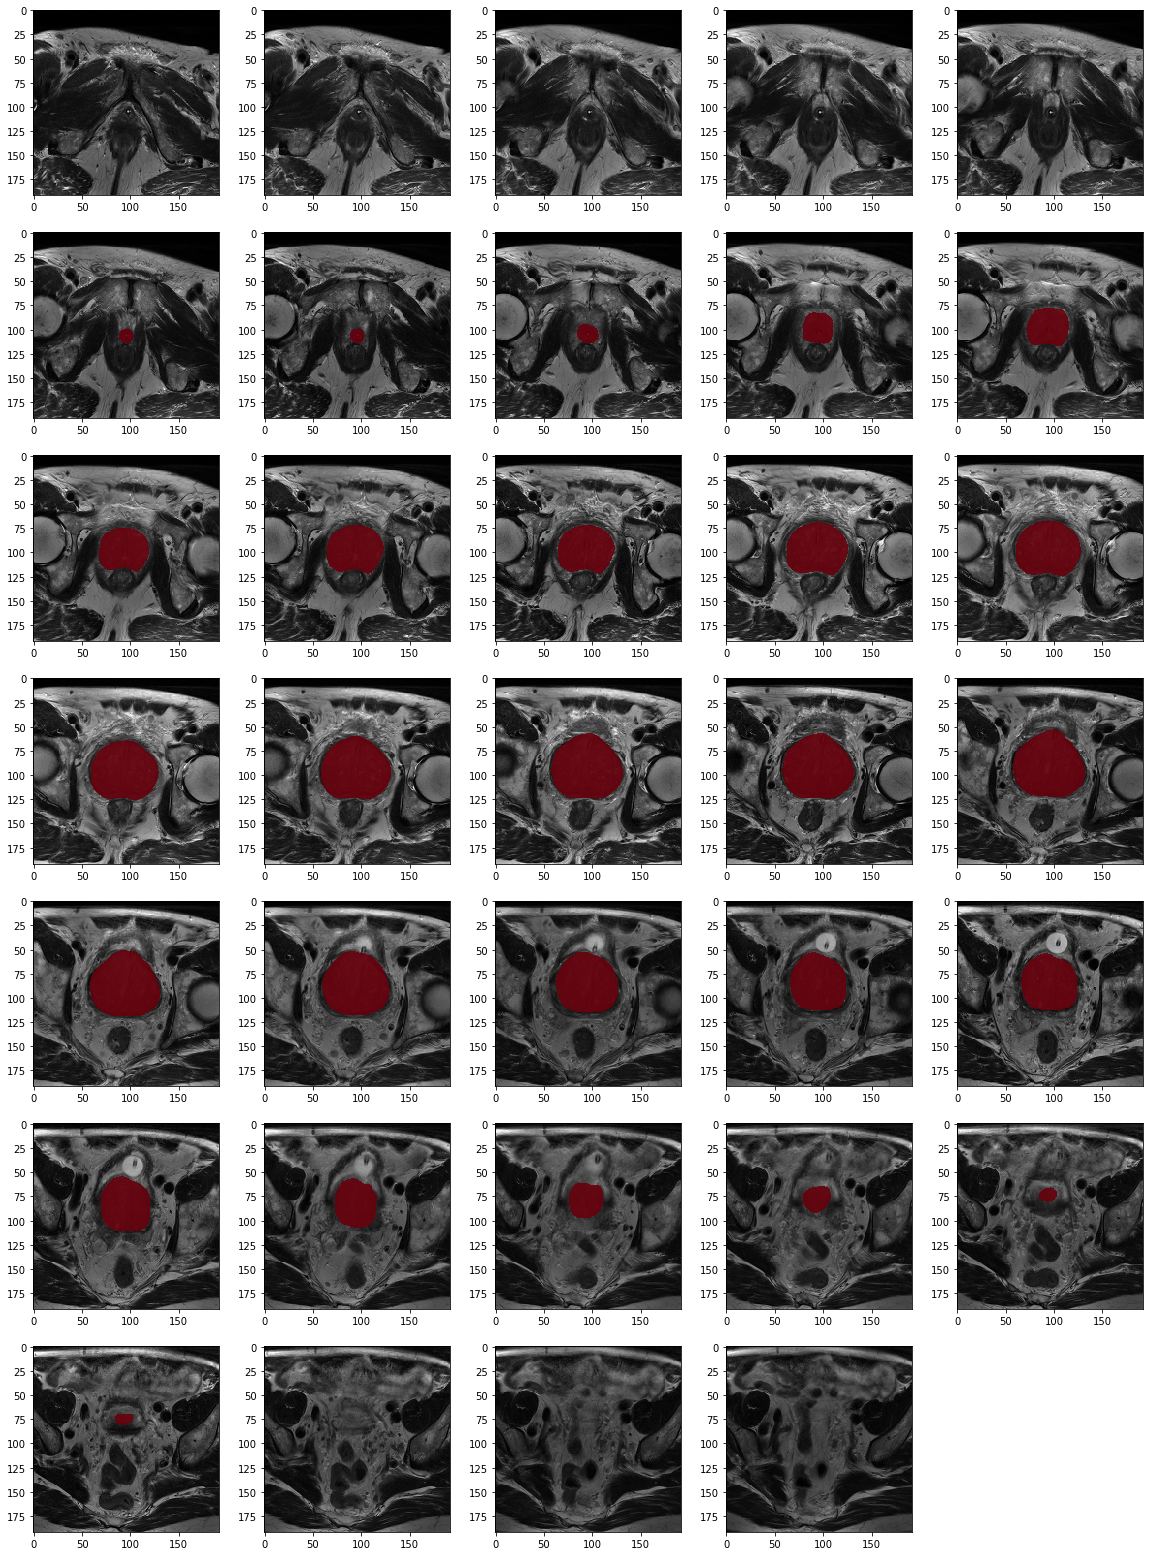

In [28]:
row = df.iloc[1319]
print(row)
image, mask = get_image_and_segmentaion(int(row["patient_id"]), int(row["study_id"]))

print(sitk.GetArrayFromImage(image).shape)
print(sitk.GetArrayFromImage(mask).shape)

plot_sitk(image, mask)

dim 0
min: 180.0 0
mean: 191.05073431241655
max: 195.0 18


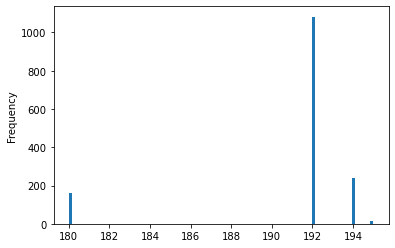

dim 1
min: 180.0 0
mean: 191.05073431241655
max: 195.0 18


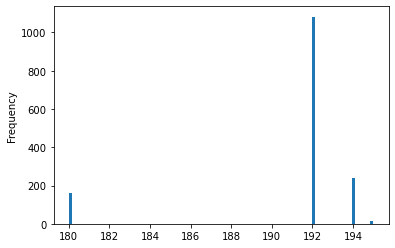

dim 2
min: 51.0 92
mean: 69.77102803738318
max: 135.0 281


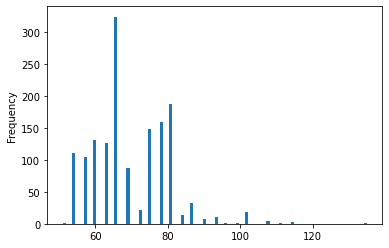

In [15]:
# plot the real extent of the scans
print("dim 0")
print("min:",  df["real_dimension_0"].min(),  df["real_dimension_0"].idxmin())
print("mean:", df["real_dimension_0"].mean())
print("max:",  df["real_dimension_0"].max(),  df["real_dimension_0"].idxmax())
df["real_dimension_0"].plot.hist(bins=100)
plt.show()

print("dim 1")
print("min:",  df["real_dimension_1"].min(),  df["real_dimension_1"].idxmin())
print("mean:", df["real_dimension_1"].mean())
print("max:",  df["real_dimension_1"].max(),  df["real_dimension_1"].idxmax())
df["real_dimension_1"].plot.hist(bins=100)
plt.show()

print("dim 2")
print("min:",  df["real_dimension_2"].min(),  df["real_dimension_2"].idxmin())
print("mean:", df["real_dimension_2"].mean())
print("max:",  df["real_dimension_2"].max(),  df["real_dimension_2"].idxmax())
df["real_dimension_2"].plot.hist(bins=100)
plt.show()

study_id                                                     1000027.0
patient_id                                                     10027.0
spacing_0                                                     0.572917
spacing_1                                                     0.572917
spacing_2                                                          3.5
size_0                                                           384.0
size_1                                                           384.0
size_2                                                            25.0
origin               (-108.06295776313, -108.0345340445, 1.41280897...
real_dimension_0                                            220.000008
real_dimension_1                                            220.000008
real_dimension_2                                             87.500001
Padding X (Start)                                                159.0
Padding X (End)                                                  157.0
Paddin

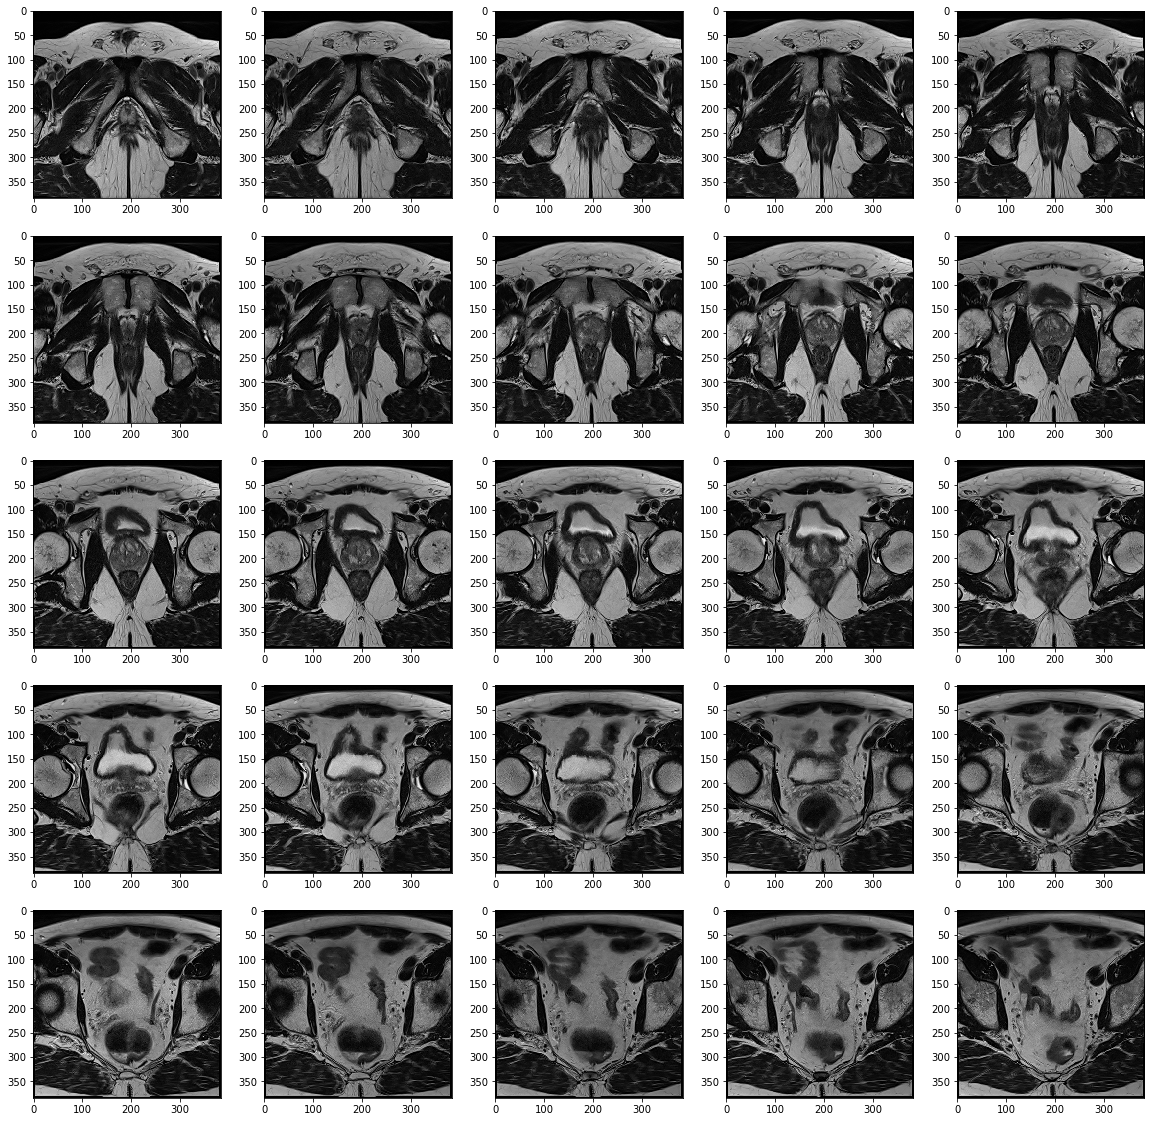

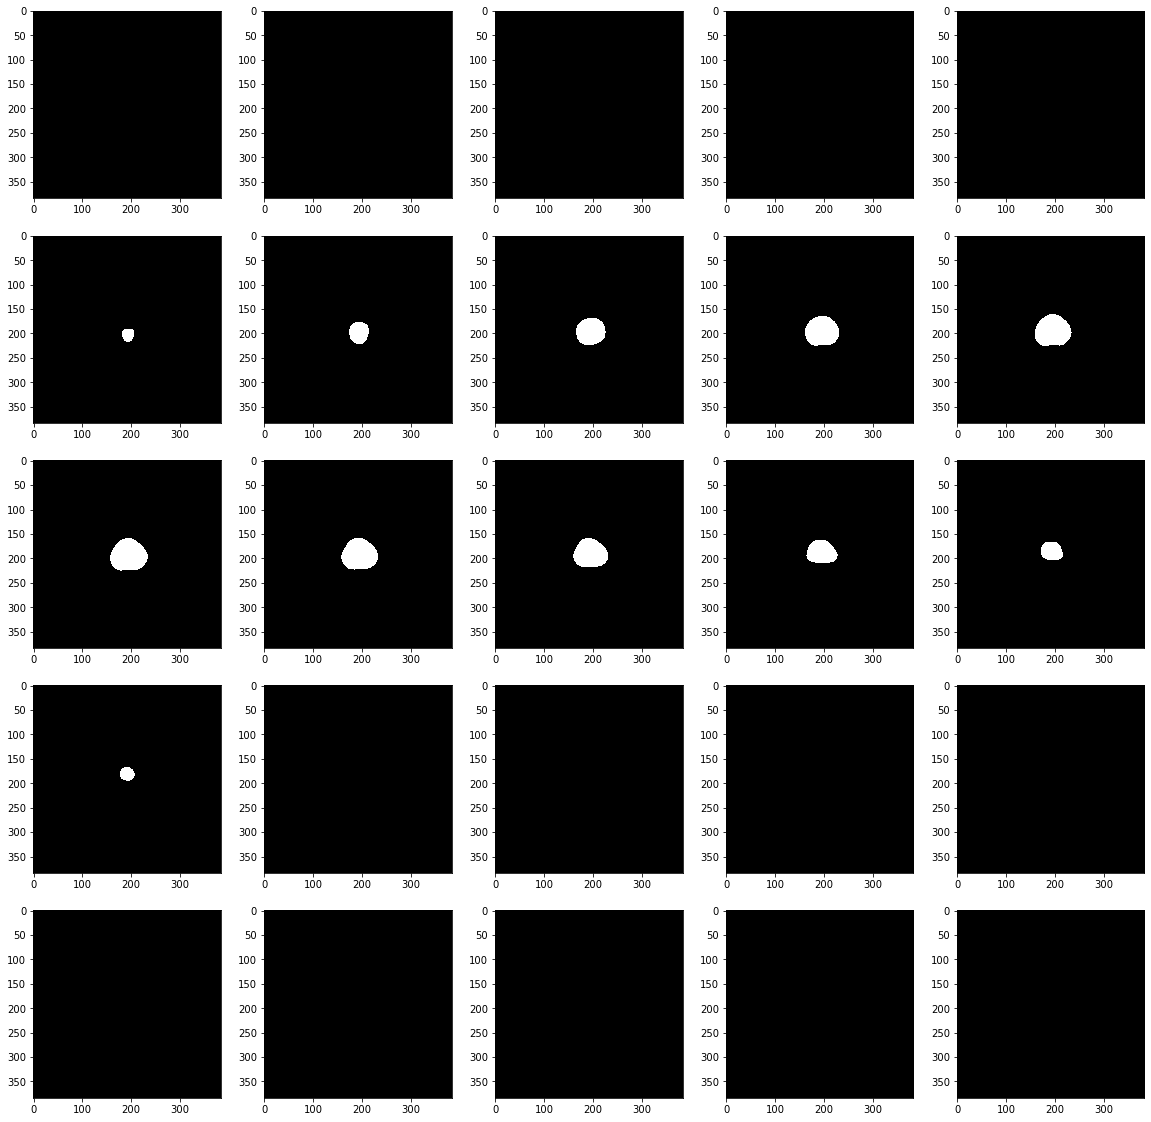

In [8]:
row = df.iloc[df["real_dimension_0"].idxmax()]
print(row)
image, mask = get_image_and_segmentaion(int(row["patient_id"]), int(row["study_id"]))

plot_sitk(image)
plot_sitk(mask)

In [9]:
target_x = 194
target_y = 194
target_z = 80

In [10]:
crop_px_x = (row["real_dimension_0"] - target_x)/row["spacing_0"]
crop_px_y = (row["real_dimension_1"] - target_y)/row["spacing_1"]
crop_px_z = (row["real_dimension_2"] - target_z)/row["spacing_2"]

print(crop_px_x, crop_px_y, crop_px_z)

45.38182992485006 45.38182992485006 2.1428573768019334


(340, 340, 23)


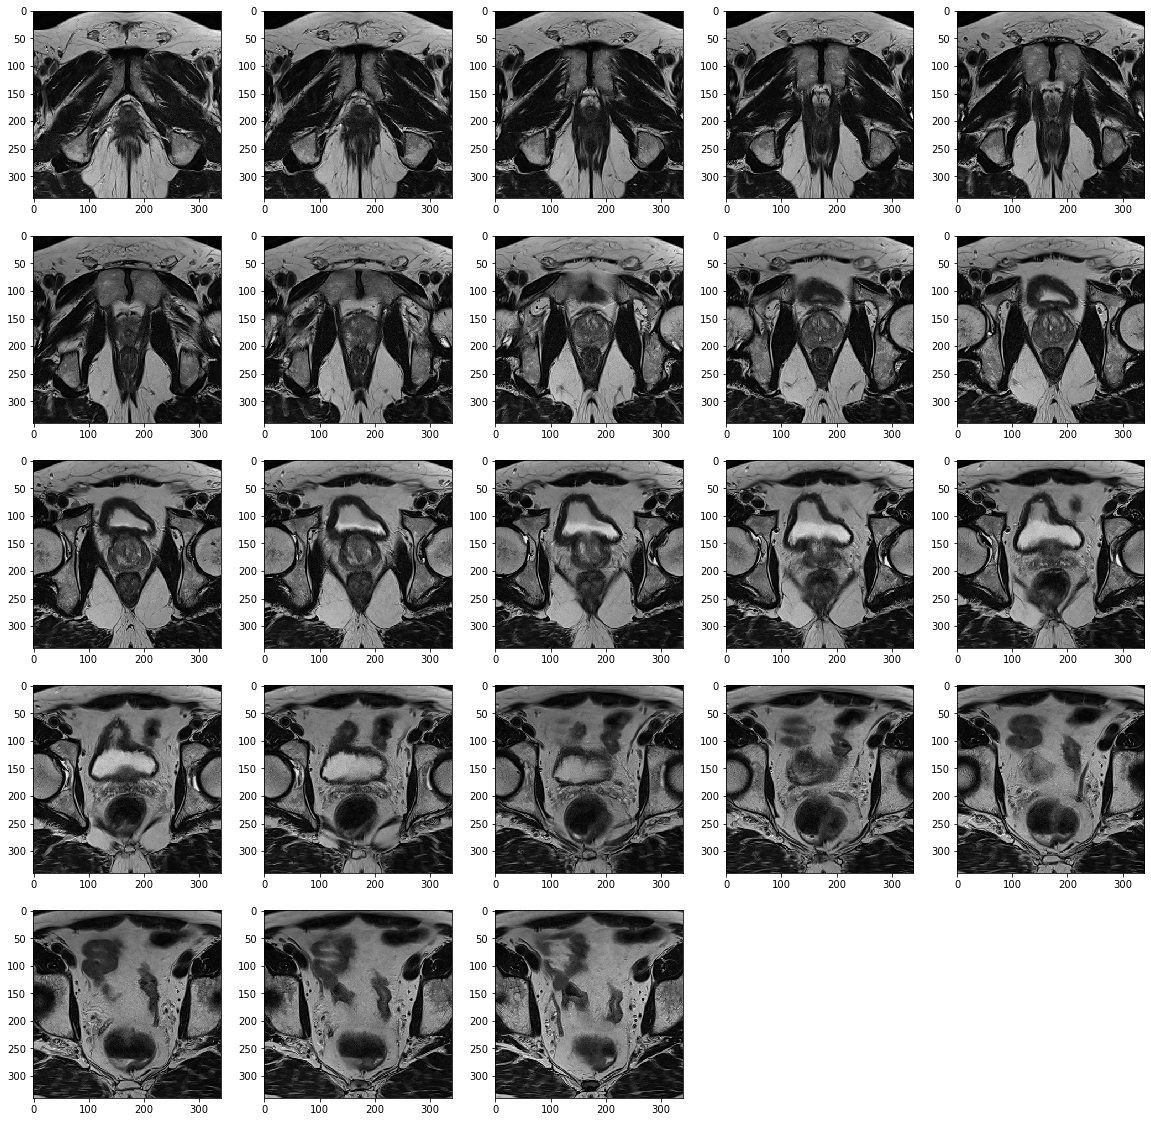

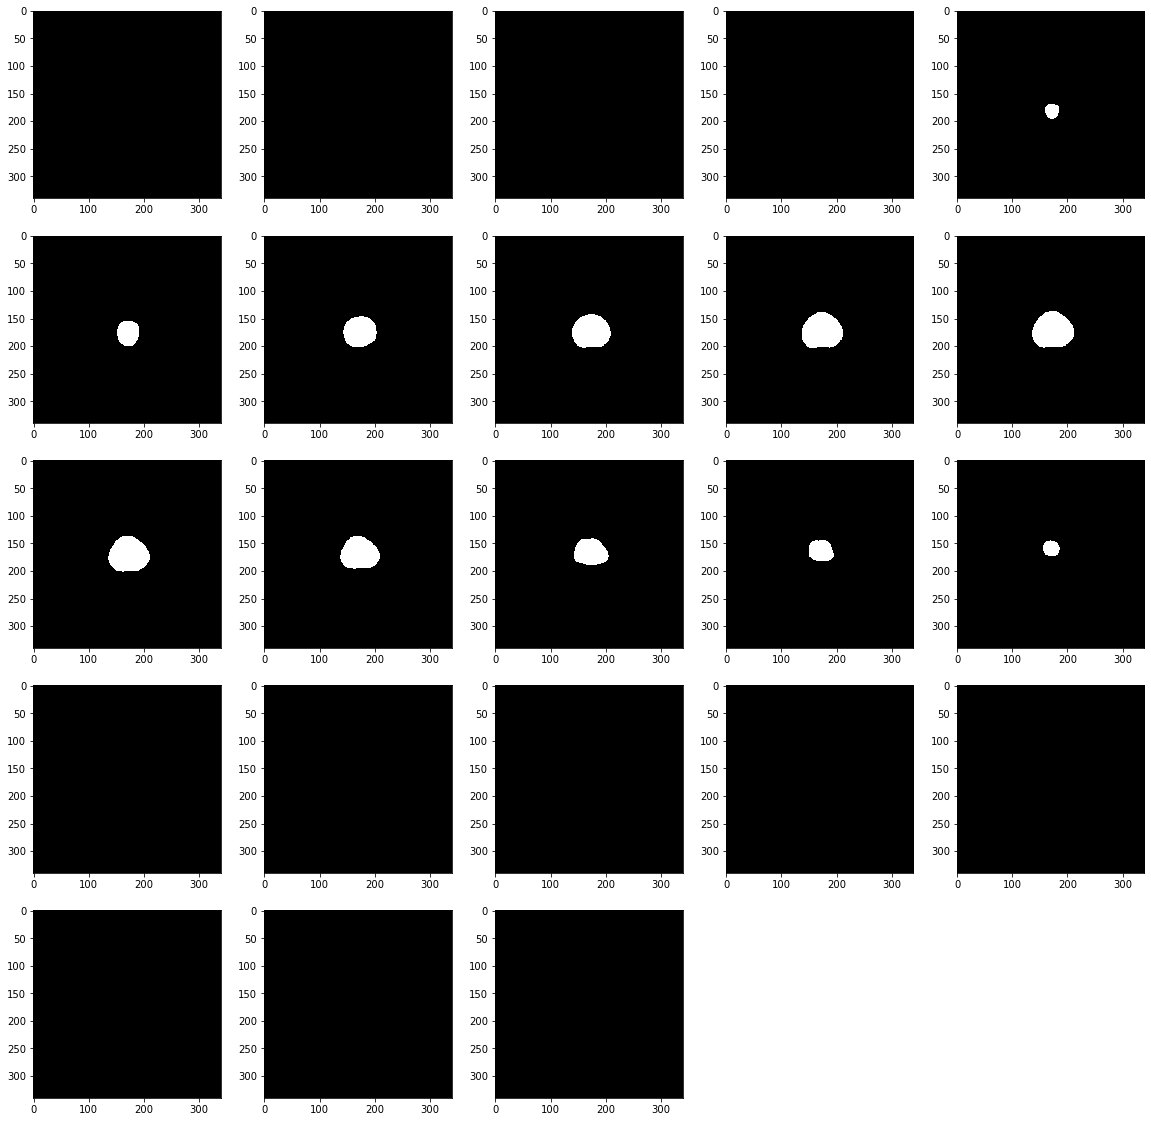

In [12]:
crop = sitk.CropImageFilter()
crop.SetLowerBoundaryCropSize([int(crop_px_x/2), int(crop_px_y/2), int(crop_px_z/2)])
crop.SetUpperBoundaryCropSize([int(crop_px_x/2), int(crop_px_y/2), int(crop_px_z/2)])
cropped_image = crop.Execute(image)
cropped_mask = crop.Execute(mask)
print(cropped_image.GetSize())
plot_sitk(cropped_image)
plot_sitk(cropped_mask)

In [ ]:

file = "{0}_{1}_{2}.mha".format(patient_id,study_id,modality)

writer = sitk.ImageFileWriter()
writer.SetFileName(data_path + patient_id + "/" +  file)
writer.Execute(cropped_image)

The following plots show the distribution of corner/paddding pixels

Padding X (Start)


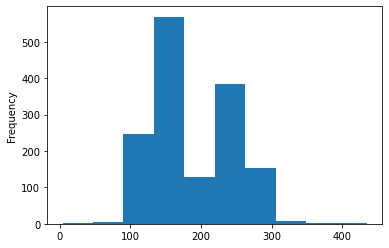

Padding X (End)


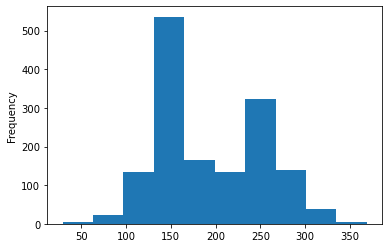

Padding Y (Start)


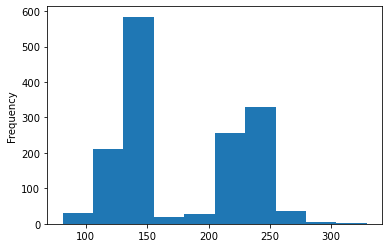

Padding Y (End)


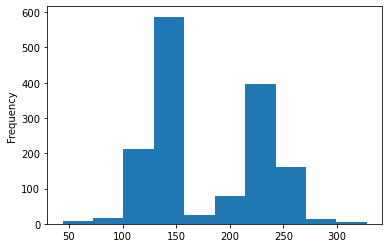

Padding Z (Start)


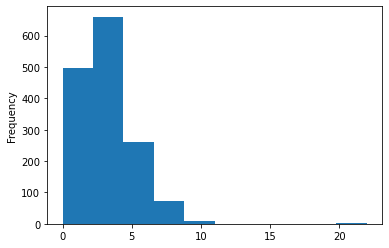

Padding Z (End)


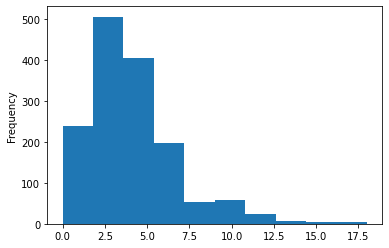

In [7]:
column=["Padding X (Start)","Padding X (End)","Padding Y (Start)","Padding Y (End)","Padding Z (Start)","Padding Z (End)"]
for x in column:
    print(x)
    df[x].plot.hist(bins=100)
    plt.show()

this is not really that helpful since we have different voxel spacings, multiplying with those spacings gives clearer picture of the actual border region

In [8]:
df["Padding X (Start) mm"] = df["Padding X (Start)"] * df["spacing_0"]
df["Padding X (End) mm"]   = df["Padding X (End)"] * df["spacing_0"]

df["Padding Y (Start) mm"] = df["Padding Y (Start)"] * df["spacing_1"]
df["Padding Y (End) mm"]   = df["Padding Y (End)"] * df["spacing_1"]

df["Padding Z (Start) mm"] = df["Padding Z (Start)"] * df["spacing_2"]
df["Padding Z (End) mm"]   = df["Padding Z (End)"] * df["spacing_2"]

Padding X (Start) mm


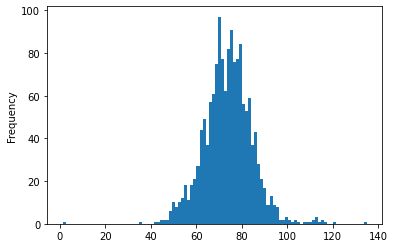

Padding X (End) mm


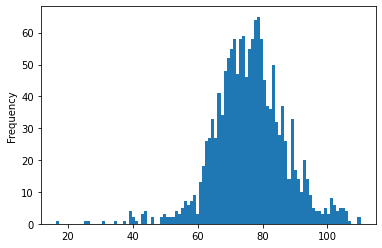

Padding Y (Start) mm


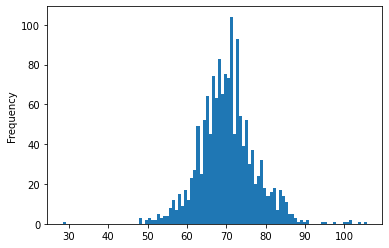

Padding Y (End) mm


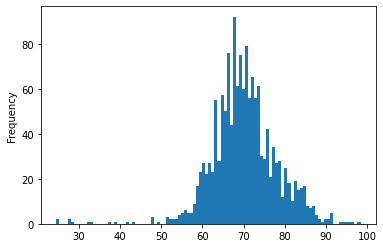

Padding Z (Start) mm


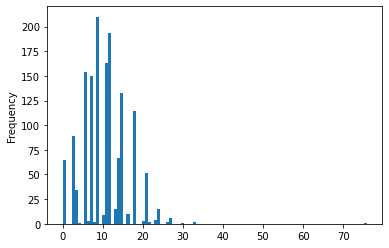

Padding Z (End) mm


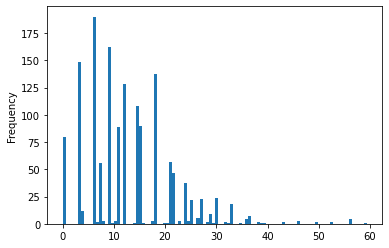

In [9]:
column=["Padding X (Start) mm","Padding X (End) mm","Padding Y (Start) mm","Padding Y (End) mm","Padding Z (Start) mm","Padding Z (End) mm"]
for x in column:
    print(x)
    df[x].plot.hist(bins=100)
    plt.show()

there is a clear outlier in the z-direction for example

In [19]:
print(df.iloc[df["Padding Y (End) mm"].idxmax()])
print(df.iloc[df["Padding Y (End) mm"].idxmin()])

study_id                                                        1000719.0
patient_id                                                        10703.0
spacing_0                                                             0.3
spacing_1                                                             0.3
spacing_2                                                             3.6
size_0                                                              640.0
size_1                                                              640.0
size_2                                                               19.0
origin                  (-97.75048839999, -83.539511142367, -32.149362...
real_dimension_0                                               192.000008
real_dimension_1                                               192.000008
real_dimension_2                                                68.400001
Padding X (Start)                                                   261.0
Padding X (End)                       

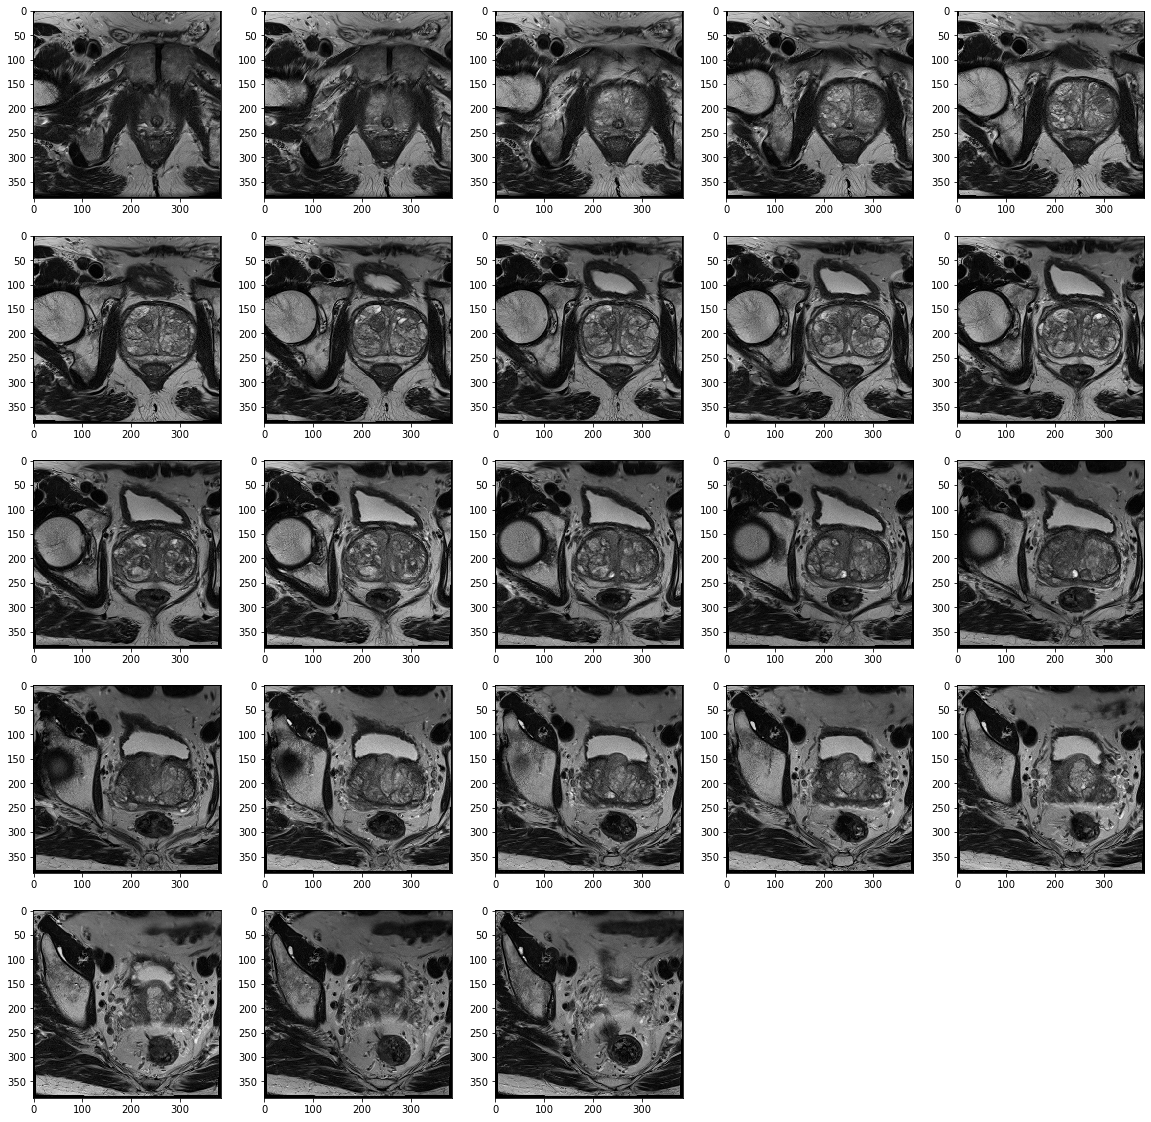

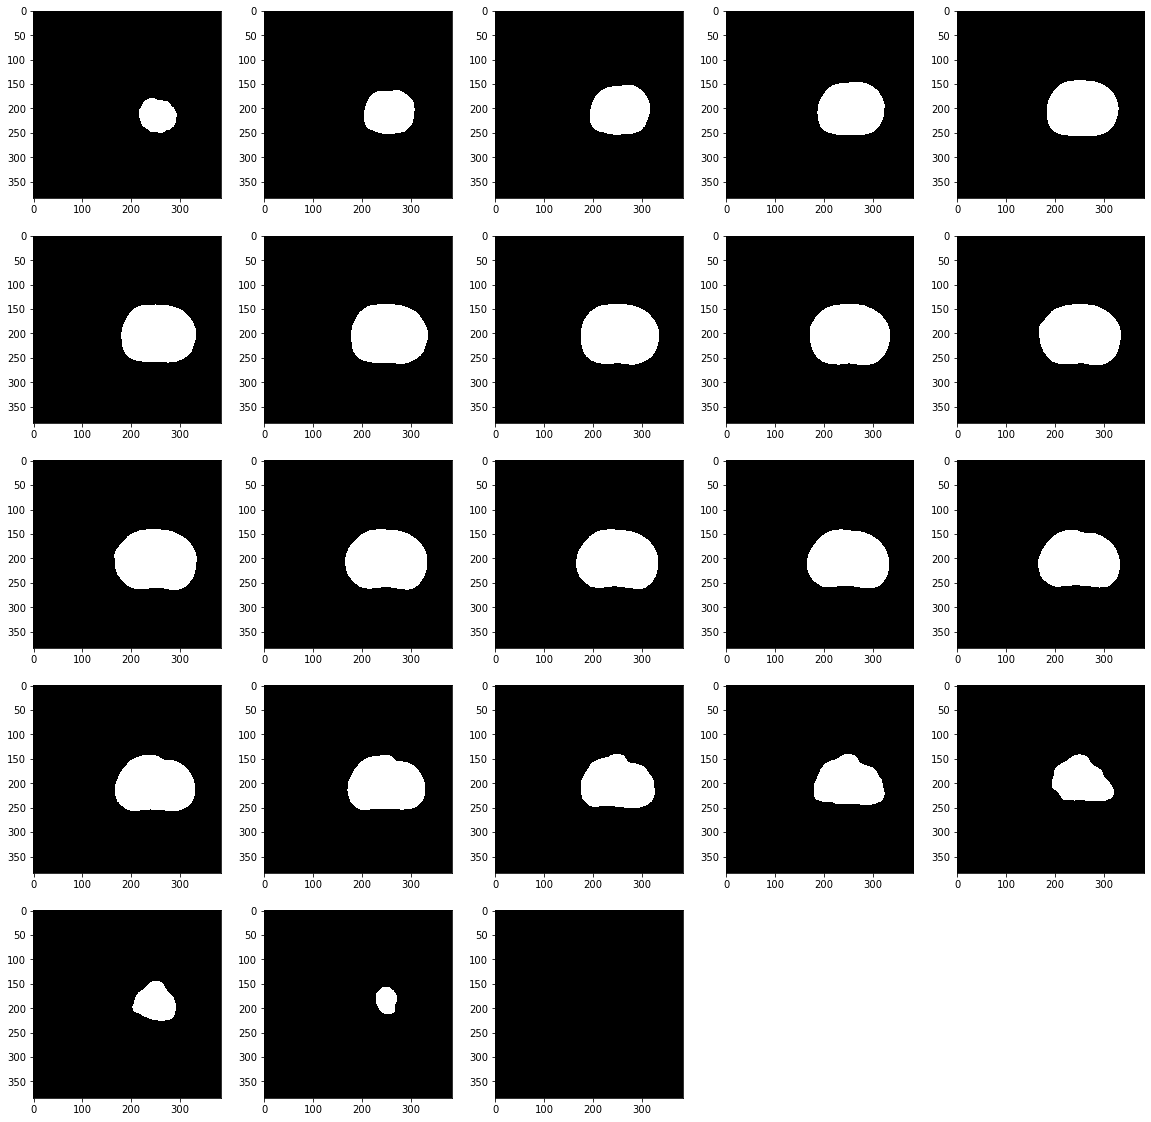

In [21]:
image, mask = get_image_and_segmentaion(int(10489), int(1000497))

plot_sitk(image)
plot_sitk(mask)

problem: we can see that prostates are not centered. It has one 1mm on the left but 103 mm on the right border

so lets calculate the average centering for now

x_center


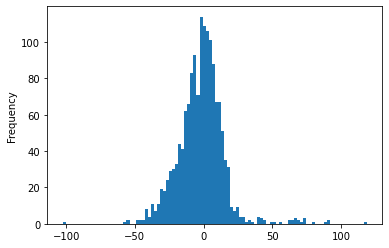

y_center


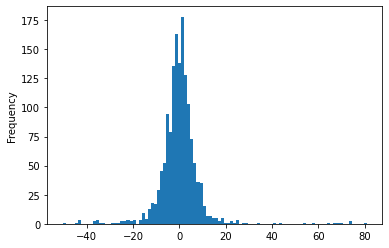

z_center


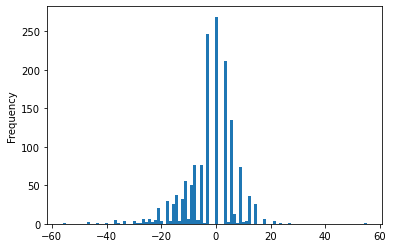

In [45]:
df["x_center"] = df["Padding X (Start) mm"] - df["Padding X (End) mm"]
df["y_center"] = df["Padding Y (Start) mm"] - df["Padding Y (End) mm"]
df["z_center"] = df["Padding Z (Start) mm"] - df["Padding Z (End) mm"]

column=["x_center", "y_center", "z_center"]
for x in column:
    print(x)
    df[x].plot.hist(bins=100)
    plt.show()

most prostates are centered but by far not all, some are really scewed

# Experiment on single image

In [ ]:
patient_id = str(int(10008))
study_id = str(int(1000008))

# Fix Problem globally

In [ ]:
for index, row in gt.iterrows():
    
    print(str(index))#, end= "\r")

    crop = sitk.CropImageFilter()
    crop.SetLowerBoundaryCropSize([200, 200, 0])
    crop.SetUpperBoundaryCropSize([200,200,0])

    patient_id = str(int(row["patient_id"]))
    study_id = str(int(row["study_id"]))

    for file in os.listdir(data_path + patient_id + "/"):
        modality = "t2w"
        string = "{0}_{1}_{2}.mha".format(patient_id,study_id,modality)
        if string == file:
            if study_id in file:
                image = sitk.ReadImage(data_path + patient_id + "/" +  file, sitk.sitkFloat32)
                cropped_image = crop.Execute(image)

                os.rename(data_path + patient_id + "/" +  file, data_path + patient_id + "/" + "orig_" +file)
                #print(data_path + patient_id + "/" +  file, data_path + patient_id + "/" + "orig_" +file)

                writer = sitk.ImageFileWriter()
                writer.SetFileName(data_path + patient_id + "/" +  file)
                writer.Execute(cropped_image)

    for file in os.listdir(seg_guer_path):
        if patient_id+"_"+study_id in file:
            
            mask = sitk.ReadImage(seg_guer_path + file, sitk.sitkUInt8)
            cropped_mask = crop.Execute(mask)

            os.rename(seg_guer_path + file, seg_guer_path + "orig_" + file)
            #print(seg_guer_path + file, seg_guer_path + "orig_" + file)
            writer = sitk.ImageFileWriter()
            writer.SetFileName(seg_guer_path + file)
            writer.Execute(cropped_mask)
            